# Analysis of network growth

## Load data

In [182]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt, matplotlib as mpl
import numpy as np
import igraph as ig
import random
from tqdm import tqdm
import statsmodels.formula.api as smf
import itertools

In [183]:
df_edges: pd.DataFrame = pd.read_pickle('../data/generated/graph/actor_graph_full.ungrouped.pkl')
df_movies: pd.DataFrame = pd.read_pickle('../data/generated/preprocessed/movies.pkl')

## Prepare temporal graphs edges

In [184]:
df_edges['movie_release'] = df_movies.set_index('fb_id').loc[df_edges.movie_fbid].movie_release.values
df_edges.sort_values('movie_release', inplace=True)

# we drop the movies release outside our period of study

print(f'length before purge : {len(df_edges)}')
df_edges.dropna(subset='movie_release', inplace=True)  # some movies do not have dates associated to them
# df_edges.drop(index=df_edges[((df_edges.movie_release <= min(years_bins)) | (df_edges.movie_release > max(years_bins)))].index, inplace=True)
# df_edges.drop(index=df_edges[(df_edges.movie_release > 2015)].index, inplace=True)
print(f'length after purge : {len(df_edges)}')

# assert min(years_bins) < df_edges.movie_release.min()
# assert df_edges.movie_release.max() <= max(years_bins)

df_edges['movie_release_year'] = df_edges['movie_release'].map(lambda t: t.year).astype(pd.Int64Dtype())

df_edges

length before purge : 2241657
length after purge : 2224839


,actor1_fbid,actor2_fbid,movie_fbid,movie_release,movie_release_year
678016,/m/0k2pyv,/m/0k2pz0,/m/044ggd,1888-01-01,1888
678017,/m/0k2pyv,/m/0k2pz6,/m/044ggd,1888-01-01,1888
678018,/m/0k2pyv,/m/0k2pzd,/m/044ggd,1888-01-01,1888
678019,/m/0k2pz0,/m/0k2pz6,/m/044ggd,1888-01-01,1888
678020,/m/0k2pz0,/m/0k2pzd,/m/044ggd,1888-01-01,1888
...,...,...,...,...,...
1118305,/m/06k6ns,/m/0fqwzd,/m/064mmw7,2016-06-08,2016
1118306,/m/06k6ns,/m/0fdc74,/m/064mmw7,2016-06-08,2016
1118307,/m/0fdc74,/m/0fqwzd,/m/064mmw7,2016-06-08,2016
1118296,/m/0736qr,/m/0fqwzd,/m/064mmw7,2016-06-08,2016


In [185]:
years = df_edges.movie_release_year.unique().astype(int)

## Model growth

We consider the initial actor network at the year 1900

https://barabasi.com/f/622.pdf

Is there preferential attachment ?

### Numerical indices

We use numerical indices instead of freebase ids, in order to index into numpy arrays later

In [186]:
codes, uniques = pd.factorize(pd.concat([df_edges.actor1_fbid, df_edges.actor2_fbid]))
df_edges['actor1_numid'] = codes[:len(df_edges)]
df_edges['actor2_numid'] = codes[len(df_edges):]
df_edges

,actor1_fbid,actor2_fbid,movie_fbid,movie_release,movie_release_year,actor1_numid,actor2_numid
678016,/m/0k2pyv,/m/0k2pz0,/m/044ggd,1888-01-01,1888,0,1
678017,/m/0k2pyv,/m/0k2pz6,/m/044ggd,1888-01-01,1888,0,2
678018,/m/0k2pyv,/m/0k2pzd,/m/044ggd,1888-01-01,1888,0,119615
678019,/m/0k2pz0,/m/0k2pz6,/m/044ggd,1888-01-01,1888,1,2
678020,/m/0k2pz0,/m/0k2pzd,/m/044ggd,1888-01-01,1888,1,119615
...,...,...,...,...,...,...,...
1118305,/m/06k6ns,/m/0fqwzd,/m/064mmw7,2016-06-08,2016,61010,52747
1118306,/m/06k6ns,/m/0fdc74,/m/064mmw7,2016-06-08,2016,61010,80735
1118307,/m/0fdc74,/m/0fqwzd,/m/064mmw7,2016-06-08,2016,80735,52747
1118296,/m/0736qr,/m/0fqwzd,/m/064mmw7,2016-06-08,2016,41038,52747


In [187]:
print(f'total {uniques.nunique()} nodes (actors)')

total 134649 nodes (actors)


### Compute degree evolution

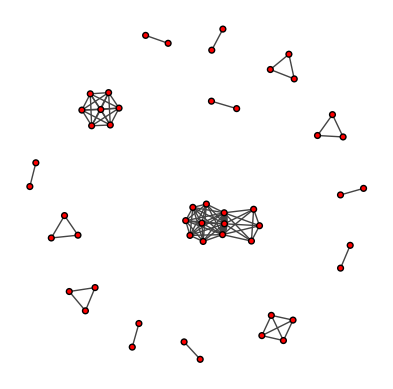

In [188]:
def get_edges_year(year: int) -> pd.DataFrame:
	"""Return weighted edges for all movies released before and on ``year``"""
	return (df_edges
		.query(f'movie_release_year <= {year}')
		.groupby(['actor1_numid', 'actor2_numid'])
		[['movie_fbid']]
		.nunique()
		.reset_index()
		.rename(columns={'movie_fbid': 'movie_count'})
	)

# test the function
random.seed(0)  # seed the random layout
fig, ax = plt.subplots()
g0 = ig.Graph.DataFrame(get_edges_year(years[10])[['actor1_numid', 'actor2_numid', 'movie_count']], directed=False, use_vids=False)
ig.plot(g0, target=ax,
	# vertex_label=g0.vs['name'], vertex_label_size=7,
	edge_width=g0.es['movie_count']
);

#### Run computation

Note : actors keep their degree even after they die !

In [189]:
if False:  # recompute
	degrees = np.zeros((uniques.nunique(), df_edges.movie_release_year.nunique()))

	for iyear, year in tqdm(enumerate(years), total=len(years)):
		g = ig.Graph.DataFrame(get_edges_year(year)[['actor1_numid', 'actor2_numid', 'movie_count']], directed=False, use_vids=False)
		# print(g.summary())
		for node, k in zip(g.vs, g.degree()):
			degrees[node['name'], iyear] = k
	
	np.savez('../data/generated/graph/network_growth/actor_graph_full_degrees.npz', degrees)

else:  # load from precomputed
	degrees = np.load('../data/generated/graph/network_growth/actor_graph_full_degrees.npz')['arr_0']

In [190]:
delta_degrees = np.diff(degrees, axis=-1)

In [191]:
# k = 0 corresponds to actors not yet born
degrees[degrees == 0] = np.nan
# Delta k = 0 corresponds to actors that don't evolve
delta_degrees[delta_degrees == 0] = np.nan

In [192]:
# convert the data to a dataframe
df_degree = pd.DataFrame(degrees, columns=years).melt(var_name='year', value_name='k', ignore_index=False)
df_degree.dropna(inplace=True)
df_degree.reset_index(inplace=True, names='actor_numid')

df_delta_degree = pd.DataFrame(delta_degrees, columns=years[:-1]).melt(var_name='year', value_name='dk', ignore_index=False)
df_delta_degree.dropna(inplace=True)
df_delta_degree.reset_index(inplace=True, names='actor_numid')

df_pref_attachment_delta = pd.merge(df_delta_degree, df_degree, how='inner', on=['actor_numid', 'year'])

In [193]:
df_pref_attachment_delta

,actor_numid,year,dk,k
0,7,1898,4.0,1.0
1,12,1898,4.0,1.0
2,7,1901,6.0,5.0
3,11,1901,6.0,5.0
4,12,1901,6.0,5.0
...,...,...,...,...
195683,51342,2015,1.0,149.0
195684,52861,2015,4.0,57.0
195685,61062,2015,1.0,114.0
195686,73797,2015,1.0,51.0


### Degree evolution

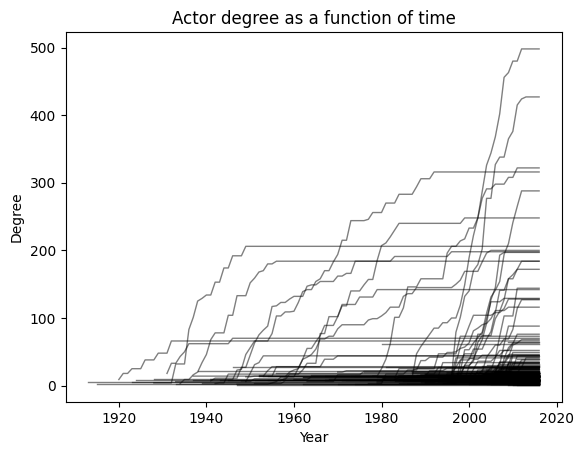

In [194]:
fig, ax = plt.subplots()
np.random.seed(0)
# we plot only 256 actors because plotting all 1.3M of them would take ages !!
ax.plot(years, degrees[np.random.randint(0, len(degrees), 256)].T, color='black', alpha=0.5, linewidth=1)
ax.set_xlabel('Year')
ax.set_ylabel('Degree')
ax.set_title('Actor degree as a function of time')
plt.show()

The degree seems to grow linearly in time, but faster when actors enter late into the graph !

### Preferential attachment

See also Jeong et al, 2003

We consider adding actors to the graph progressively, and not considering edges created between existing actors.

Each actor appears for the first time in a movie, and using the first movie release date we can prune the edges that do not correspond to the first addition.

We want to estimate

$\Pi(k_i) = \frac{k_i}{\sum_j k_j} \approx \frac{\text{number of new connections to node } i}{\text{total number of new connections}}$

##### Create the pruned edgelist

In [195]:
df_newactors = pd.concat(
	# include edges i -> j and j -> i
	[df_edges, df_edges.rename(columns={'actor1_fbid': 'actor2_fbid', 'actor2_fbid': 'actor1_fbid'})],
	ignore_index=True  # WARNING : this is important, since otherwise there are duplicate indices, which fucks with the drop operation
)
df_newactors['actor1_firstmovie_date'] = (df_newactors
	.groupby('actor1_fbid')
	[['movie_release']]
	.min()
	.loc[df_newactors.actor1_fbid]
	.values
)
# is this where we see the actor1 for the first time ?
df_newactors['actor1_entrypoint'] = df_newactors['actor1_firstmovie_date'] == df_newactors['movie_release']
# I end up not dropping the edges, because the edges that connect actors together still raise the degree of the existing nodes,
# and we measure that degree when adding new actors
# df_newactors.drop(index=df_newactors[df_newactors['actor1_firstmovie_date'] != df_newactors['movie_release']].index, inplace=True)
df_newactors.sort_values(['movie_release', 'actor1_fbid'], inplace=True)
df_newactors.reset_index(drop=True, inplace=True)

In [196]:
# we ensure we have not lost actors during the process
assert df_newactors[df_newactors.actor1_entrypoint].actor1_fbid.nunique() == uniques.nunique()

In [197]:
print(f'fraction of original edges which add a new actor to the network : {len(df_newactors[df_newactors.actor1_entrypoint])/len(df_edges):.2%}')

fraction of original edges which add a new actor to the network : 68.35%


In [198]:
# inspect the data, this is an interesting movie because some of the actors already exist in the graph
df_newactors.query('movie_fbid == "/m/0b6jn8h"')

,actor1_fbid,actor2_fbid,movie_fbid,movie_release,movie_release_year,actor1_numid,actor2_numid,actor1_firstmovie_date,actor1_entrypoint
28,/m/02q36h4,/m/03cs750,/m/0b6jn8h,1899-01-01,1899,7,10,1896-12-24,False
29,/m/02q36h4,/m/0g9ckxm,/m/0b6jn8h,1899-01-01,1899,7,13,1896-12-24,False
30,/m/02q36h4,/m/0g9cky8,/m/0b6jn8h,1899-01-01,1899,7,119621,1896-12-24,False
31,/m/02q36h4,/m/0cqkn,/m/0b6jn8h,1899-01-01,1899,7,11,1896-12-24,False
32,/m/02q36h4,/m/0g9ckx8,/m/0b6jn8h,1899-01-01,1899,7,12,1896-12-24,False
33,/m/03cs750,/m/0cqkn,/m/0b6jn8h,1899-01-01,1899,10,11,1899-01-01,True
34,/m/03cs750,/m/0g9ckx8,/m/0b6jn8h,1899-01-01,1899,10,12,1899-01-01,True
35,/m/03cs750,/m/0g9ckxm,/m/0b6jn8h,1899-01-01,1899,10,13,1899-01-01,True
36,/m/03cs750,/m/0g9cky8,/m/0b6jn8h,1899-01-01,1899,10,119621,1899-01-01,True
37,/m/03cs750,/m/02q36h4,/m/0b6jn8h,1899-01-01,1899,7,10,1899-01-01,True


##### Add actors by batches

In order to have a good estimate, we batch edges together by movie release year, so that the probability estimate is not too noisy

cut : binning every 10 years<br>
qcut : binning 12 quartiles

In [266]:
if False:
	# import time

	# I also the distinction between in-degree and out-degree,
	# because that distinction is not there in the original graph
	g = ig.Graph.DataFrame(df_newactors.query('movie_release_year <= 1900')[['actor1_fbid', 'actor2_fbid']], directed=False, use_vids=False)
	components = []  # (num_connected, num_movies, year)
	pi_k = []  # (nb_new_received, nb_new_nodes, degree, actor_fbid, year)
	total_movies = df_newactors.query('movie_release_year <= 1900').movie_fbid.nunique()

	for year, df_edges_year in tqdm(df_newactors.query('1900 < movie_release_year').groupby('movie_release_year', sort=False)):
		new_actors = df_edges_year[df_edges_year.actor1_entrypoint].actor1_fbid.unique()
		nb_new_nodes = len(new_actors)
		nb_received_map = df_edges_year[df_edges_year.actor1_entrypoint].actor2_fbid.value_counts()

		# compute the empirical probability of receiving a connection
		# t0 = time.time()
		degree_lookup = dict(zip([ v['name'] for v in g.vs ], g.indegree()))
		for old_actor in g.vs:
			actor_fbid = old_actor['name']
			nb_new_received = nb_received_map.get(actor_fbid, 0)
			pi_k.append(( nb_new_received, nb_new_nodes, degree_lookup[actor_fbid], actor_fbid, year ))
		# tqdm.write(f'compute degree {time.time()-t0:.2f}')

		# t0 = time.time()
		g.add_vertices(new_actors)
		g.add_edges(zip(df_edges_year.actor1_fbid, df_edges_year.actor2_fbid))
		# tqdm.write(f'add vertices {time.time()-t0:.2f}')

		# compute the number of components and movies at this stage
		# t0 = time.time()
		total_movies += df_edges_year.movie_fbid.nunique()
		components.append(( len(g.connected_components(mode='weak')), total_movies, year ))
		# tqdm.write(f'compute components {time.time()-t0:.2f}')

	df_pref_attachment_BA = pd.DataFrame(pi_k, columns=['nb_new_received', 'nb_new_nodes', 'k', 'actor_fbid', 'year'])
	df_pref_attachment_BA['pi'] = df_pref_attachment_BA.nb_new_received / df_pref_attachment_BA.nb_new_nodes
	df_components = pd.DataFrame(components, columns=['num_connected', 'num_movies', 'year'])
	
	if False:  # save results to disk
		pd.to_pickle(df_pref_attachment_BA, '../data/generated/graph/network_growth/pref_attachment_BA.pkl')
		pd.to_pickle(df_components, '../data/generated/graph/network_growth/components.pkl')

else:  # load from savefile
	df_pref_attachment_BA = pd.read_pickle('../data/generated/graph/network_growth/pref_attachment_BA.pkl')
	df_components = pd.read_pickle('../data/generated/graph/network_growth/components.pkl')

100%|██████████| 115/115 [00:26<00:00,  4.35it/s]


In [267]:
# division by 0 for the Pi computation
df_pref_attachment_BA.nb_new_nodes.replace(0, np.nan, inplace=True)  # division by 0
df_pref_attachment_BA.dropna(inplace=True, subset='nb_new_nodes')
# edge double counting
df_pref_attachment_BA['k'] /= 2
# perform binning again
df_pref_attachment_BA['year_bin'] = pd.cut(df_pref_attachment_BA.year, range(1900, 2010+1, 10), precision=0)
df_pref_attachment_BA['year_qbin'] = pd.qcut(df_pref_attachment_BA.year, q=11, precision=0)
df_pref_attachment_BA

,nb_new_received,nb_new_nodes,k,actor_fbid,year,pi,year_bin,year_qbin
0,0,4.0,1.0,/m/01720p,1901,0.0,"(1900.0, 1910.0]","(1900.0, 1956.0]"
1,0,4.0,8.0,/m/02q36h4,1901,0.0,"(1900.0, 1910.0]","(1900.0, 1956.0]"
2,0,4.0,1.0,/m/03c073,1901,0.0,"(1900.0, 1910.0]","(1900.0, 1956.0]"
3,0,4.0,7.0,/m/03cs750,1901,0.0,"(1900.0, 1910.0]","(1900.0, 1956.0]"
4,0,4.0,2.0,/m/041m3s,1901,0.0,"(1900.0, 1910.0]","(1900.0, 1956.0]"
...,...,...,...,...,...,...,...,...
3804191,0,5.0,14.0,/m/0k9t525,2014,0.0,NaN,"(2012.0, 2014.0]"
3804192,0,5.0,14.0,/m/0kn07kk,2014,0.0,NaN,"(2012.0, 2014.0]"
3804193,0,5.0,14.0,/m/0kn07l4,2014,0.0,NaN,"(2012.0, 2014.0]"
3804194,0,5.0,14.0,/m/0kn07n1,2014,0.0,NaN,"(2012.0, 2014.0]"


In [268]:
# check how many samples we have per bin
# few samples especially in the beginning ! this will be reflected in the CI
df_pref_attachment_BA.groupby('year_bin')[['actor_fbid']].count()

,actor_fbid
year_bin,
"(1900, 1910]",623
"(1910, 1920]",11498
"(1920, 1930]",38297
"(1930, 1940]",78936
"(1940, 1950]",123046
"(1950, 1960]",182430
"(1960, 1970]",263408
"(1970, 1980]",374271
"(1980, 1990]",510833


In [269]:
# qcut yields more even results.. but less fine-grained at the start
df_pref_attachment_BA.groupby('year_qbin')[['actor_fbid']].count()

,actor_fbid
year_qbin,
"(1900.0, 1956.0]",353014
"(1956.0, 1970.0]",345224
"(1970.0, 1980.0]",374271
"(1980.0, 1987.0]",340569
"(1987.0, 1993.0]",355259
"(1993.0, 1998.0]",344625
"(1998.0, 2002.0]",318959
"(2002.0, 2006.0]",378171
"(2006.0, 2009.0]",339293


##### Exploring results

A naive way of proceeding would be to take each sample (i.e. each node growth), and divide the number of received connections by the number of connections created by the addition of new nodes. This gives one $\Pi(k)$ estimate for each node, which we can scatter.

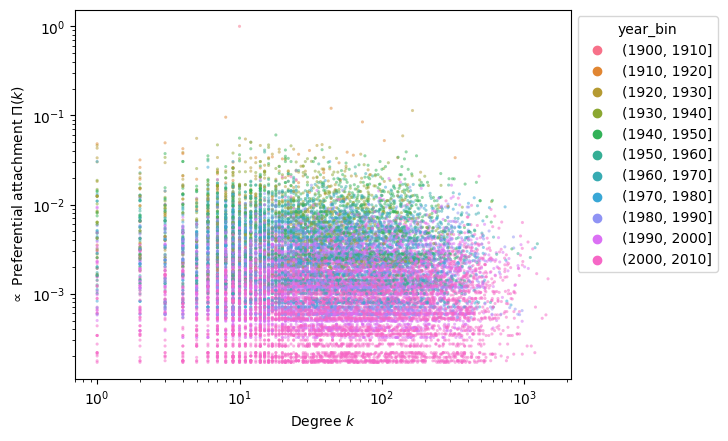

In [270]:
np.random.seed(0)  # seed random sample. we sample the dataframe with 500k points, since we have over 3.8M points !
ax = sns.scatterplot(df_pref_attachment_BA.sample(500_000), x='k', y='pi', hue='year_bin', linewidth=0, alpha=0.5, s=5)
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('Degree $k$')
ax.set_ylabel('$\propto$ Preferential attachment $\Pi(k)$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

Through the noise, we see maybe a general trend of raising Pi(k) as k grows.

A better way of proceeding is through the aggregation of the results, and normalizing $\Pi(k)$ numerically.

In [271]:
def compute_pi_kappa(df_pa, bin='year_bin'):
	# overall result
	pi = (df_pa
		.groupby('k')
		.nb_new_received
		.sum()
		.div(df_pa.groupby('k').nb_new_nodes.sum())
	)
	pi /= pi.sum()
	kappa = pi.cumsum()

	# grouped by year
	pi_bin = (df_pa
		.groupby([bin, 'k'])
		.nb_new_received
		.sum()
		.div(df_pa.groupby([bin, 'k']).nb_new_nodes.sum())
	)
	pi_bin /= pi_bin.groupby(bin).sum()
	kappa_bin = pi_bin.groupby(bin).cumsum()
	pi_bin = pi_bin.reset_index(name='pi')
	kappa_bin = kappa_bin.reset_index(name='kappa')

	return (pi, pi_bin), (kappa, kappa_bin)

In [272]:
(pi, pi_yearbin), (kappa, kappa_yearbin) = compute_pi_kappa(df_pref_attachment_BA, 'year_bin')

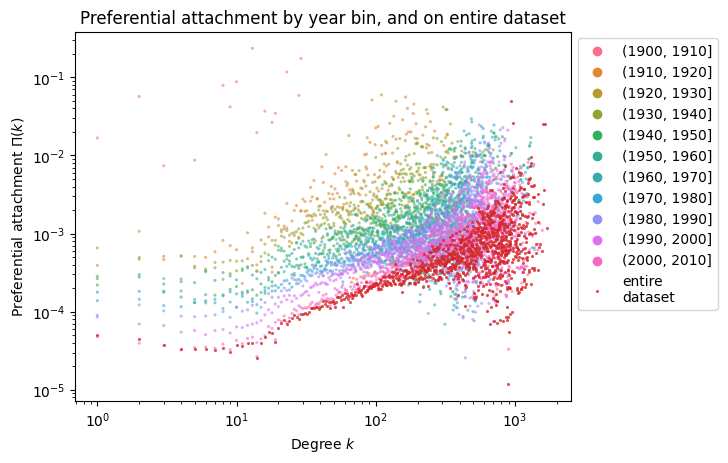

In [273]:
ax = sns.scatterplot(pi_yearbin, x='k', y='pi', hue='year_bin', linewidth=0, alpha=0.6, s=5)
sns.scatterplot(pi, linewidth=0, s=5, alpha=0.8, color='tab:red', label='entire\ndataset', ax=ax)
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylabel('Preferential attachment $\\Pi(k)$')
ax.set_xlabel('Degree $k$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Preferential attachment by year bin, and on entire dataset')
plt.show()

This is quite an improvement over the scatterplot, however the paper Jeong et al. suggests to use the cumulative function to reduce noise :

$$
\kappa(k) = \int^k \mathrm{d}k' \; \Pi(k') \sim k^{\alpha+1}
$$

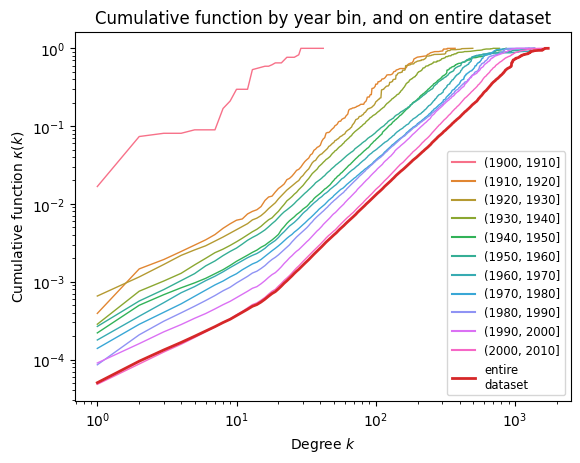

In [274]:
# ax = sns.scatterplot(kappa_yearbin, x='k', y='kappa', hue='year_bin', linewidth=0, alpha=0.5, s=5)
ax = sns.lineplot(kappa_yearbin, x='k', y='kappa', hue='year_bin', linewidth=1)
sns.lineplot(kappa, color='tab:red', linewidth=2, label='entire\ndataset', ax=ax)
sns.move_legend(ax, loc='lower right', fontsize='small')
ax.set_ylabel('Cumulative function $\\kappa(k)$')
ax.set_xlabel('Degree $k$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('Cumulative function by year bin, and on entire dataset')
plt.show()

The B-A model seems to work well, in that the cumulative function indeed seems to follow a power law ! There is a kink around $10^1$, where the slope increases.

We also notice that the different bins seems to have very similar behavior visually. To verify this, we fit a linear regression on the loglog plot (ignoring the kink, its contribution will enter the confidence interval of the fit)

In [275]:
def compute_fitcoefs(df_pa):
	fitcoefs = { 'year_bin': [], 'year_qbin': [] }

	for groupby_col in fitcoefs:
		(_, _), (_, kappa_yearbin) = compute_pi_kappa(df_pa, groupby_col)
		for bin, kappa_bin in kappa_yearbin.dropna().groupby(groupby_col):
			# no fit corresponds to no new actors added during that timeframe
			if len(kappa_yearbin) >= 2:
				model = smf.ols(formula="log_kappa ~ log_k", data=dict(log_k=np.log10(kappa_bin.k), log_kappa=np.log10(kappa_bin.kappa)))
				res = model.fit()
				# display(res.summary())
				alpha_plus_one = (res.params['log_k'], *res.conf_int().loc['log_k'])
				fitcoefs[groupby_col].append((bin, alpha_plus_one[0]-1, alpha_plus_one[1]-1, alpha_plus_one[2]-1))
			else:
				fitcoefs[groupby_col].append((bin, np.nan, np.nan, np.nan))

	fitcoefs = { key: pd.DataFrame(values, columns=['bin', 'alpha', 'ci_lower', 'ci_upper']) for key, values in fitcoefs.items() }

	(_, _), (kappa, _) = compute_pi_kappa(df_pa)
	model = smf.ols(formula="log_kappa ~ log_k", data=dict(log_k=np.log10(kappa.index), log_kappa=np.log10(kappa.values)))
	res = model.fit()
	alpha_plus_one = (res.params['log_k'], *res.conf_int().loc['log_k'])
	fitcoefs['all'] = (alpha_plus_one[0]-1, alpha_plus_one[1]-1, alpha_plus_one[2]-1)

	return fitcoefs

In [276]:
dfs_fitcoefs_BA = compute_fitcoefs(df_pref_attachment_BA)
dfs_fitcoefs_BA

{'year_bin':              bin     alpha  ci_lower  ci_upper
 0   (1900, 1910]  0.141757  0.033514  0.249999
 1   (1910, 1920]  0.498001  0.462248  0.533753
 2   (1920, 1930]  0.527126  0.495474  0.558779
 3   (1930, 1940]  0.472728  0.445946  0.499509
 4   (1940, 1950]  0.520454  0.502145  0.538763
 5   (1950, 1960]  0.346552  0.329967  0.363138
 6   (1960, 1970]  0.487931  0.470415  0.505447
 7   (1970, 1980]  0.545403  0.532750  0.558056
 8   (1980, 1990]  0.571544  0.563416  0.579672
 9   (1990, 2000]  0.657092  0.646943  0.667241
 10  (2000, 2010]  0.719634  0.710226  0.729043,
 'year_qbin':                  bin     alpha  ci_lower  ci_upper
 0   (1900.0, 1956.0]  0.386407  0.374252  0.398561
 1   (1956.0, 1970.0]  0.437294  0.420734  0.453853
 2   (1970.0, 1980.0]  0.545403  0.532750  0.558056
 3   (1980.0, 1987.0]  0.549399  0.541116  0.557682
 4   (1987.0, 1993.0]  0.565217  0.554230  0.576204
 5   (1993.0, 1998.0]  0.641443  0.629548  0.653338
 6   (1998.0, 2002.0]  0.664241  0

#### Summary : is there preferential attachment ?

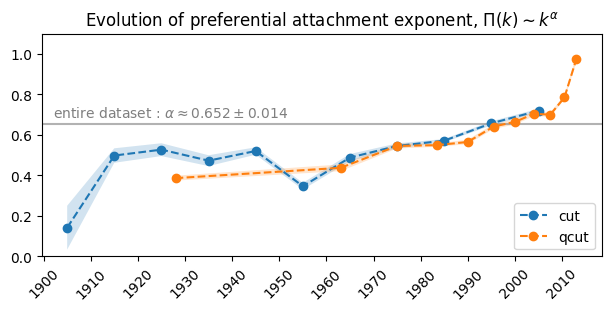

In [277]:
fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)

mid_years = dfs_fitcoefs_BA['year_bin'].bin.map(lambda x: (x.left + x.right)/2)
qmid_years = dfs_fitcoefs_BA['year_qbin'].bin.map(lambda x: (x.left + x.right)/2)

alpha_all, alpha_all_lower, alpha_all_higher = dfs_fitcoefs_BA['all']
ax.axhline(alpha_all, alpha=0.6, color='tab:gray')
ax.annotate(f'entire dataset : $\\alpha \\approx {alpha_all:.3f} \pm {alpha_all_higher-alpha_all_lower:.3f}$',
	xy=(0.02, alpha_all+0.02), va='bottom', xycoords=('axes fraction', 'data'), color='tab:gray')
ax.fill_between(mid_years, dfs_fitcoefs_BA['year_bin'].ci_lower, dfs_fitcoefs_BA['year_bin'].ci_upper, alpha=0.2)
ax.fill_between(qmid_years, dfs_fitcoefs_BA['year_qbin'].ci_lower, dfs_fitcoefs_BA['year_qbin'].ci_upper, alpha=0.2)
ax.plot(mid_years, dfs_fitcoefs_BA['year_bin'].alpha, 'o--', label='cut')
ax.plot(qmid_years, dfs_fitcoefs_BA['year_qbin'].alpha, 'o--', label='qcut')

ax.set_xticks([ int(x.left) for x in dfs_fitcoefs_BA['year_bin'].bin ] + [ int(dfs_fitcoefs_BA['year_bin'].bin.iloc[-1].right) ])
ax.set_xticklabels(ax.get_xticks(), rotation=45)
ax.legend(loc='lower right')

ax.set_ylim((0.0, 1.1))
ax.set_title('Evolution of preferential attachment exponent, $\\Pi(k) \\sim k^{\\alpha}$')
plt.show()

Interpretation :

- According to the B-A model, we are the sublinear attachment regime
- The B-A model gives larger exponents $\alpha$ than the degree evolution model : there is higher preferential attachment for new actors, than for already existing actors -> well established actors rely on their already existing connections to create new connections, instead of searching for other high-degree actors
- Both model give the same trends :
  - Rapid growth before ~1915 : cinema is a niche, and only the only way to get into it is to connect to already existing clusters
  - Slow growth between ~1915 and ~1980 : it is becoming easier to get into cinema, allowing small clusters to exist, without relying on well-established actors
  - Rapid growth post ~1980 : we suspect globalization and appearance of internet made the actor graph more connected, and makes it "less expensive" to connect to high-degree actors rather than smaller but more local actors

### Degree distribution in the B-A model

<img src="../assets/Screenshot from 2022-12-13 20-42-26.png">

In [278]:
def p_k_th(alpha: float, k_mean: float):
	def p_k(k: np.ndarray) -> np.ndarray:
		p = k**(-alpha) * np.exp(-2/(k_mean*(1-alpha)) * k**(1-alpha))
		p /= p.sum()
		return p
	return p_k

In [296]:
degrees_final = degrees[:, -1].copy()
degrees_final.sort()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


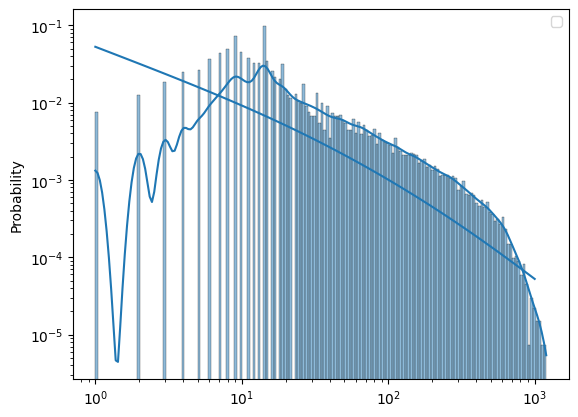

In [306]:
ax = sns.histplot(degrees_final, kde=True, log_scale=(True, True), stat='probability')
ax.set_autoscale_on(False)

k = np.logspace(0, 3, 100)

year_to_idx = { year: i for i, year in enumerate(years) }
k_means = [ np.nanmean(degrees[:, year_to_idx[int(qmid_year)]]) for qmid_year in qmid_years ]
p_k = np.vstack([ p_k_th(alpha, k_mean)(k) for alpha, k_mean in zip(dfs_fitcoefs_BA['year_qbin'].alpha, k_means) ]).sum(axis=0)
p_k /= p_k.sum()
ax.plot(k, p_k)

ax.legend()
plt.show()

In [281]:
# Problem : the cutoff is too sharp with our fits. it looks like the true alpha is larger
# maybe there is a problem with our fits ?

# Hypothesis : the A-B model does not take into account that the nodes can create further connections between them !!
# However physically, we know many existing actors continue playing together and bonding with other actors, which increases their mutual degree ! -> large tail

# Furthermore dead actors cannot stay in the graph, and thus "bias" the results to no attachment

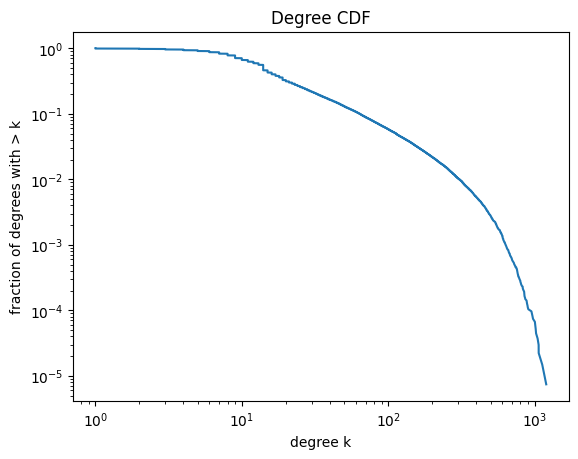

In [282]:
fig, ax = plt.subplots()
ax.plot(degrees_final, (np.arange(1, len(degrees_final)+1)/len(degrees_final))[::-1])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('fraction of degrees with > k')
ax.set_xlabel('degree k')
ax.set_title('Degree CDF')
plt.show()

TODO : only consider links added through arrival of new nodes, do not consider links added internally

-> but physically, we need preferential attachment to nodes that still exist ! dead actors cannot be connected to anymore, and it would bias the results

### Growth of hubs

<img src="../assets/Screenshot from 2022-12-13 21-01-28.png">

In [283]:
kmax = np.nanmax(degrees, axis=0)

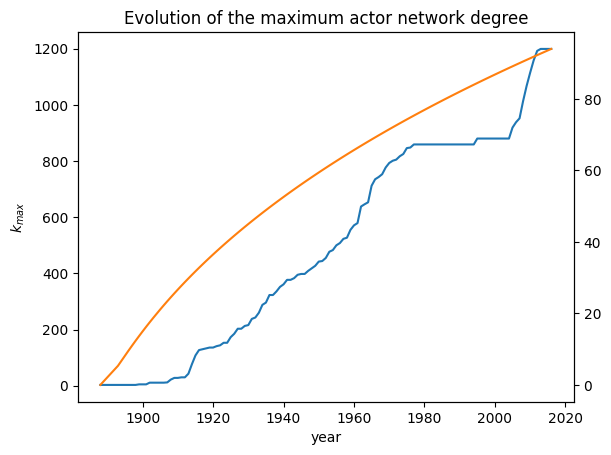

In [284]:
fig, ax = plt.subplots()
ax.plot(years, kmax)
ax.twinx().plot(years, np.log(years-years.min()+1)**(1/(1-0.652)), color='tab:orange')
ax.set_xlabel('year')
ax.set_ylabel('$k_{max}$')
ax.set_title('Evolution of the maximum actor network degree')
plt.show()

### Growth of components

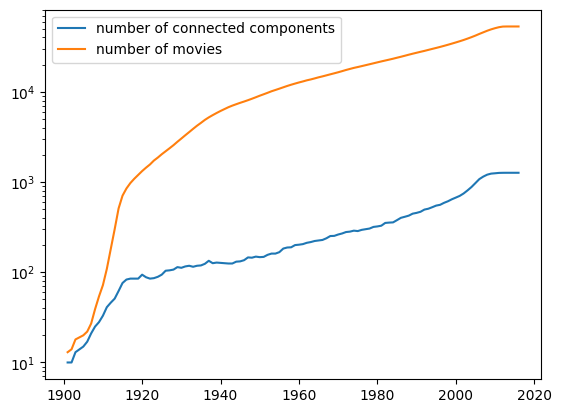

In [285]:
# at the start, every movie adds a new unique component, then the clusters start to appear !
fig, ax = plt.subplots()
ax.plot(df_components.year, df_components.num_connected, label='number of connected components')
ax.plot(df_components.year, df_components.num_movies, label='number of movies')
ax.set_yscale('log')
ax.legend()
plt.show()

# Archive

Unused cells, might still be useful in the future

In [ ]:
def fit_alpha(df_pa: pd.DataFrame) -> tuple[dict[str, pd.DataFrame], list[mpl.axes.Axes]]:
	fitcoefs = { 'year_bin': [], 'year_qbin': [] }
	axes = []

	for groupby_col in fitcoefs:
		grid_arrangement = (6, 2)
		fig, axs = plt.subplots(
			ncols=grid_arrangement[0], nrows=grid_arrangement[1],
			figsize=(grid_arrangement[0]*4, grid_arrangement[1]*3),
			constrained_layout=True, sharex=True, sharey=True)

		for ax, (year_bin, df_bin) in zip(axs.flat, df_pa.dropna().groupby(groupby_col)):
			ax.plot(df_bin.k, df_bin.pi, '.', markersize=2, alpha=0.2)
			
			# no fit corresponds to no new actors added during that timeframe
			if len(df_bin) >= 2:
				model = smf.ols(formula="log_dk ~ log_k", data=dict(log_k=np.log10(df_bin.k), log_dk=np.log10(df_bin.pi)))
				res = model.fit()
				fitcoefs[groupby_col].append((res.params['log_k'], *res.conf_int().loc['log_k']))
				x = np.logspace(0, 3, 2)
				ax.plot(x, 10**res.predict(dict(log_k=np.log10(x))), '--')
			else:
				fitcoefs[groupby_col].append((np.nan, np.nan, np.nan))

			ax.set_xscale('log')
			ax.set_yscale('log')
			ax.set_xlabel('Degree of receiving node $k$')
			ax.set_ylabel('Preferential attachment $\\Pi(k)$')
			ax.label_outer()
			ax.set_title(f'Movie released between {int(year_bin.left+1)} and {int(year_bin.right)}')

		axes.append(axs)
		# plt.show()

	fitcoefs = { key: pd.DataFrame(values, columns=['alpha', 'ci_lower', 'ci_upper']) for key, values in fitcoefs.items() }

	return fitcoefs, axes

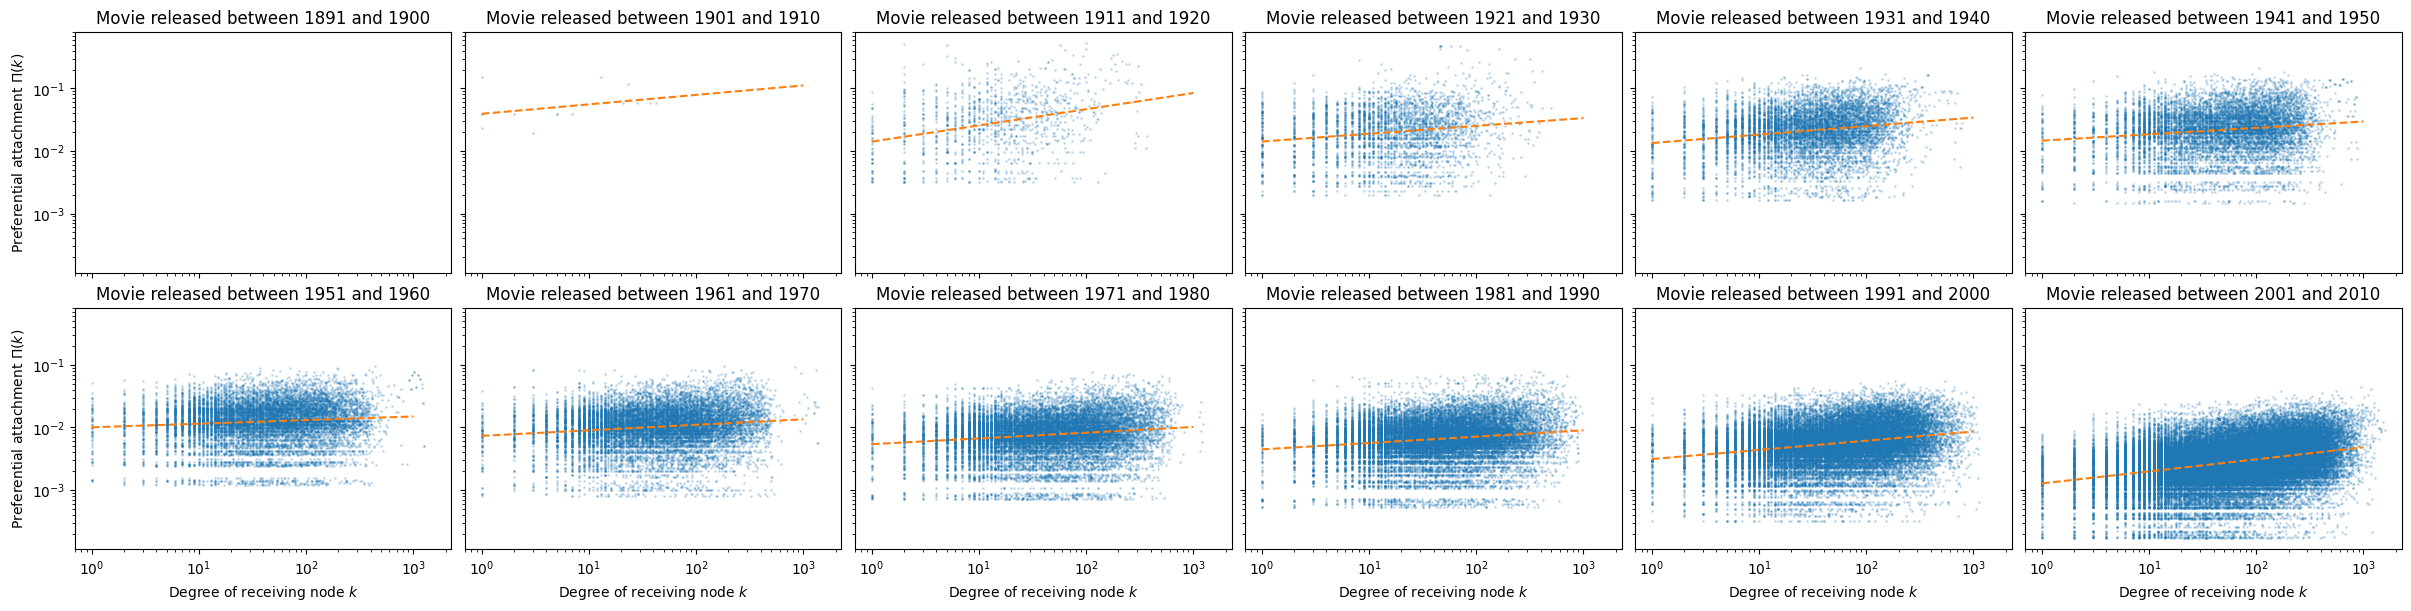

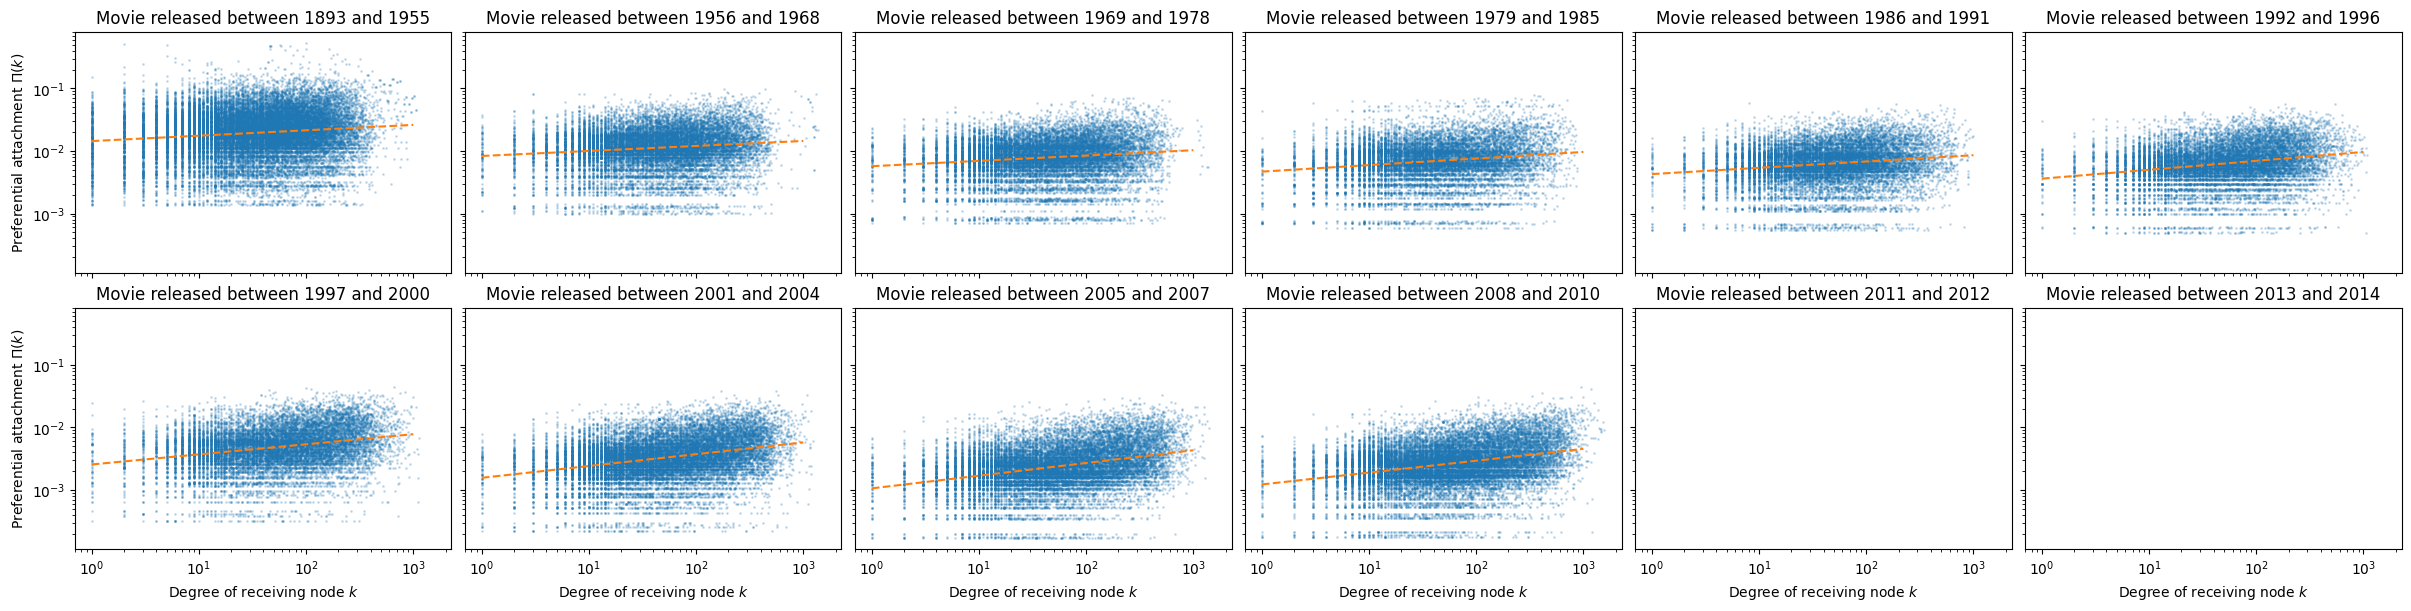

In [ ]:
dfs_fitcoefs_BA, axes_BA = fit_alpha(df_pref_attachment_BA.query('nb_new_nodes > 40 and pi > 0'))
plt.show()

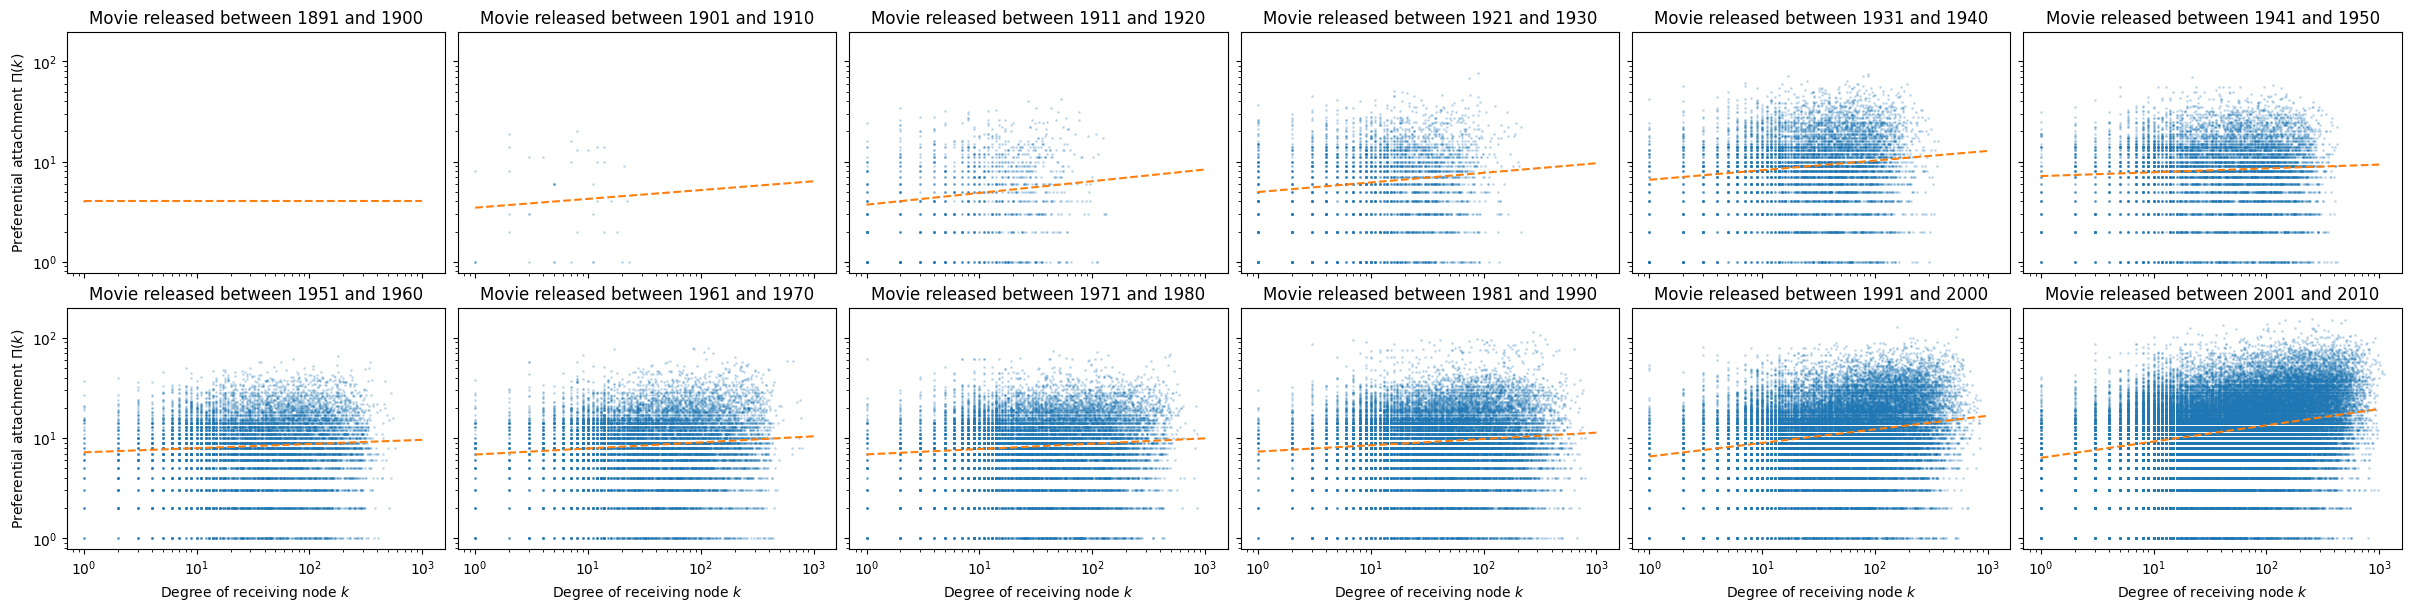

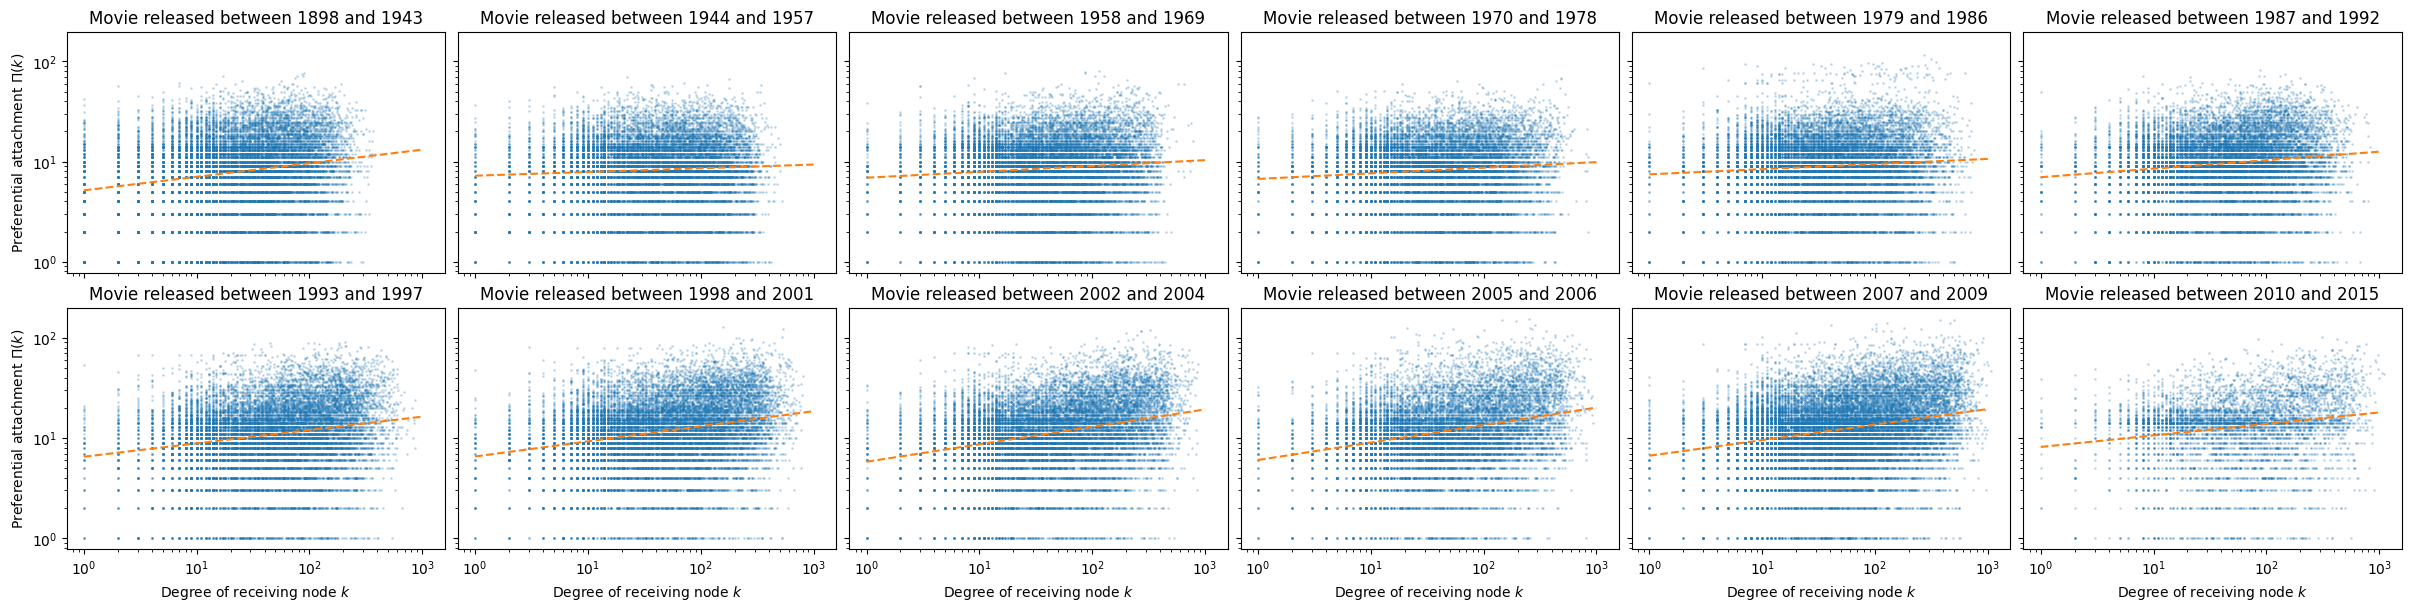

In [ ]:
dfs_fitcoefs_delta, axes_delta = fit_alpha(df_pref_attachment_delta.rename(columns={'dk': 'pi'}))
for axs in axes_delta:
	for ax in axs.flat:
		ax.set_label('Rate of change $\\Delta k \\sim \\Pi(k)$')
		ax.label_outer()
plt.show()

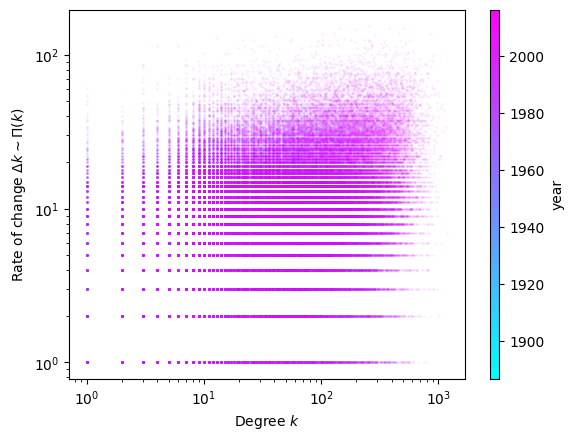

In [ ]:
fig, ax = plt.subplots()

cmap = mpl.cm.get_cmap('cool')(np.linspace(0, 1, len(years)))
cax, kw = mpl.colorbar.make_axes(ax, pad=0.05, aspect=40)
cb = mpl.colorbar.ColorbarBase(cax, cmap='cool', values=years, label='year')
yearcolor = { year: color for year, color in zip(years, cmap) }

for iyear, year in enumerate(years[:-1]):
	ax.plot(degrees[:, iyear], delta_degrees[:, iyear], 'o', color=yearcolor[year], alpha=0.05, markersize=1)

ax.set_xlabel('Degree $k$')
ax.set_ylabel('Rate of change $\\Delta k \\sim \Pi(k)$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

# difficult to see anything... let's do binning on years !

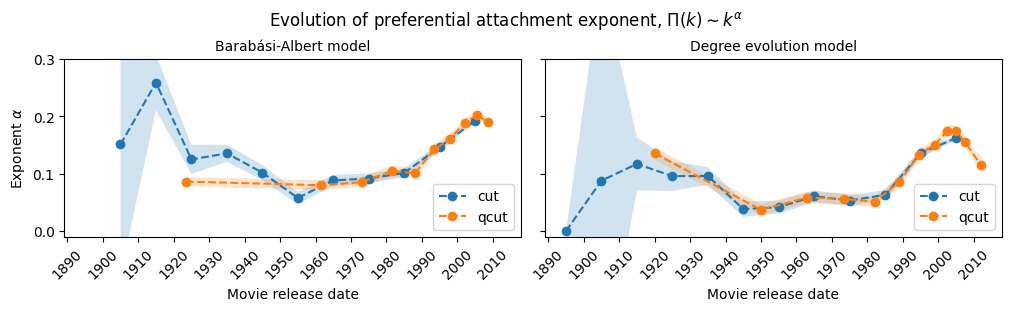

In [ ]:
fig, axs = plt.subplots(figsize=(10, 3), sharex=True, sharey=True, ncols=2, constrained_layout=True)

for df_pa, dfs_fitcoefs, ax in zip([df_pref_attachment_BA, df_pref_attachment_delta], [dfs_fitcoefs_BA, dfs_fitcoefs_delta], axs):
	mid_years = df_pa.year_bin.dropna().unique().map(lambda x: (x.left + x.right)/2)
	qmid_years = df_pa.year_qbin.dropna().unique().map(lambda x: (x.left + x.right)/2)

	ax.plot(mid_years, dfs_fitcoefs['year_bin'].alpha, 'o--', label='cut')
	ax.plot(qmid_years, dfs_fitcoefs['year_qbin'].alpha, 'o--', label='qcut')
	ax.fill_between(mid_years, dfs_fitcoefs['year_bin'].ci_lower, dfs_fitcoefs['year_bin'].ci_upper, alpha=0.2)
	ax.fill_between(qmid_years, dfs_fitcoefs['year_qbin'].ci_lower, dfs_fitcoefs['year_qbin'].ci_upper, alpha=0.2)
	ax.set_xticks([ int(x.left) for x in df_pa.year_bin.dropna().unique() ] + [ int(df_pa.year_bin.dropna().unique()[-1].right) ])
	ax.set_xticklabels(ax.get_xticks(), rotation=45)
	ax.legend(loc='lower right')
	ax.set_xlabel('Movie release date')
	ax.set_ylabel('Exponent $\\alpha$')
	ax.label_outer()

axs[0].set_ylim((-0.01, 0.3))
axs[0].set_title('Barabási-Albert model', fontsize='medium')
axs[1].set_title('Degree evolution model', fontsize='medium')
fig.suptitle('Evolution of preferential attachment exponent, $\\Pi(k) \\sim k^{\\alpha}$')
plt.show()

In [ ]:
# overall result
pi_internal = (df_pref_attachment_delta
	.groupby('k')
	.dk
	.mean()  # I think this is incorrect..
)
pi_internal /= pi_internal.sum()
# kappa = pi_internal.cumsum()
pi_internal

k
1.0       0.000461
2.0       0.000496
3.0       0.000519
4.0       0.000528
5.0       0.000547
            ...   
1067.0    0.002586
1094.0    0.001761
1114.0    0.002421
1158.0    0.001871
1192.0    0.000385
Name: dk, Length: 882, dtype: float64

In [ ]:
kappa_internal = pi_internal.cumsum()

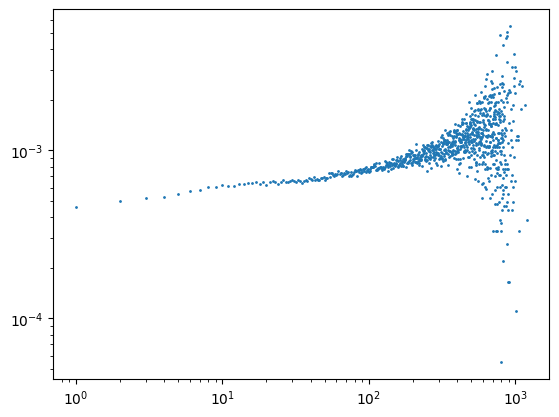

In [ ]:
plt.plot(pi_internal.index, pi_internal.values, '.', markersize=2)
plt.xscale('log')
plt.yscale('log')

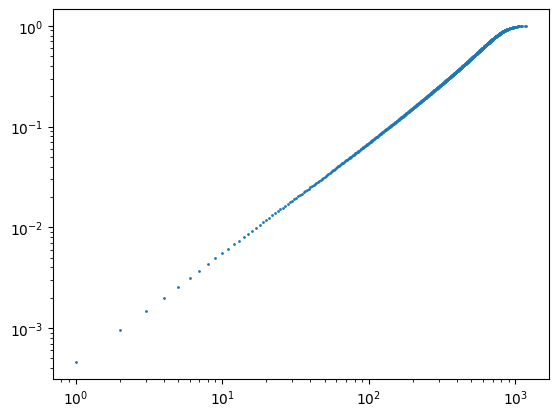

In [ ]:
plt.plot(kappa_internal.index, kappa_internal.values, '.', markersize=2)
plt.xscale('log')
plt.yscale('log')

In [ ]:
model = smf.ols(formula="log_kappa ~ log_k", data=dict(log_k=np.log10(kappa_internal.index), log_kappa=np.log10(kappa_internal.values)))
res = model.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_kappa   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.728e+05
Date:                Sat, 17 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:11:17   Log-Likelihood:                 2124.6
No. Observations:                 882   AIC:                            -4245.
Df Residuals:                     880   BIC:                            -4236.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4851      0.004   -802.135      0.000      -3.494      -3.477
log_k          1.1698      0.002    687.635      0.000       1.166       1.173
==============================================================================
Omnibus:                      130.376   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              751.363
Skew:                           0.519   Prob(JB):                    6.98e-164
Kurtosis:                       7.401   Cond. No.                         17.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Model with internal growth

The preferential attachment $\Pi(k_i) = \frac{k_i}{\sum_j k_j}$ can be empirically estimated through $\Pi(k_i) \sim \Delta k_i$. We plot it for each node, and for every year.

This approach has the advantage to also take into account new edges between already existing nodes

We use a log scale, since we expect preferential attachment to behave as a power law, $\Pi(k) \sim k^{\alpha}$. Note that this also deals with the problem of dead actors present in the data. Since for dead actors $\Delta k_i = 0$, the log scale crops out these datapoints

<img src="../assets/Screenshot from 2022-12-13 20-43-30.png">
<br>
<img src="../assets/Screenshot from 2022-12-13 20-43-41.png">

We fit $\Pi(k) \sim \Delta k \sim k^{\alpha}$, so that $\log \Pi(k) = \alpha \log k + (b + \text{normalization constant})$

In [ ]:
df_pref_attachment_delta['year_bin'] = pd.cut(df_pref_attachment_delta.year, range(1890, 2010+1, 10), precision=0)
df_pref_attachment_delta['year_qbin'] = pd.qcut(df_pref_attachment_delta.year, q=12, precision=0)

In [ ]:
# check how many samples we have per bin
# few samples especially in the beginning ! this will be reflected in the CI
df_pref_attachment_delta.groupby('year_bin')[['k']].count()

,k
year_bin,
"(1890, 1900]",2
"(1900, 1910]",43
"(1910, 1920]",1315
"(1920, 1930]",3903
"(1930, 1940]",8992
"(1940, 1950]",10043
"(1950, 1960]",12744
"(1960, 1970]",14597
"(1970, 1980]",17597


In [ ]:
# qcut yields more even results.. but less fine-grained at the start
df_pref_attachment_delta.groupby('year_qbin')[['k']].count()

,k
year_qbin,
"(1897.0, 1943.0]",17142
"(1943.0, 1957.0]",16029
"(1957.0, 1969.0]",16826
"(1969.0, 1978.0]",15335
"(1978.0, 1986.0]",16826
"(1986.0, 1992.0]",15696
"(1992.0, 1997.0]",16729
"(1997.0, 2001.0]",17793
"(2001.0, 2004.0]",16889
